## Confidence bands around AUC

The sensitivity, specificity and accuracy are proportions, thus the according confidence intervals can be calculated by using standard methods for proportions. Two types of 95% confidence intervals are generally constructed around proportions: asymptotic and exact 95% confidence interval.

The exact confidence interval is constructed by using binomial distribution to reach an exact estimate. Asymptotic confidence interval is calculated by assuming a normal approximation of the sampling distribution. DeLong is an asymptotically exact method to evaluate the uncertainty of an AUC (DeLong et al., 1988)

The choice of these two types of confidence interval depends on whether the sample proportion is a good approximation of normal distribution. If the number of event is very small or if the sample size is very small, the normal assumption cannot be met. Thus, exact confident interval is desired.


### References
- https://search.r-project.org/CRAN/refmans/pROC/html/roc.test.html
- https://github.com/andrija-djurovic/PDtoolkit/blob/main/R/14_DISCRIMINATORY_POWER.R
- https://www.anaesthetist.com/mnm/stats/roc/Findex.htm
- https://www.bis.org/publ/bcbs_wp14.htm
- https://lexjansen.com/nesug/nesug10/hl/hl07.pdf
- https://tbrieder.org/epidata/course_reading/b_altman.pdf

In [9]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import time
from scipy.stats import norm
import scipy.stats
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Settings
pd.set_option('display.float_format', '{:.3f}'.format)


### A. Generate test dataset

In [2]:
def generate_independent_data(n_samples):
    np.random.seed(42)  # Seed for reproducibility

    # Generate random scores normally distributed around 0, scale 1
    scores = np.random.randn(n_samples)

    # Generate defaults, where higher scores have a lower probability of default
    # Using a logistic function to map scores to probabilities
    probabilities = 1 / (1 + np.exp(-scores))
    defaults = np.random.binomial(1, probabilities)

    # Create DataFrame
    data = pd.DataFrame({
        'score': scores,
        'default': defaults
    })
    return data

# Generate a base dataset
base_dataset_size = 100  # A reasonable starting size for our tests
base_data = generate_independent_data(base_dataset_size)

### B. Create algorithms for confidence bands

In [3]:
def calculate_gini(scores, defaults):
    """Calculate the Gini coefficient from scores and defaults using the ROC AUC method."""
    # return 2 * roc_auc_score(defaults, scores) - 1
    return roc_auc_score(defaults, scores)

def bootstrap_conf_band(data, n_iterations=100, scale_factor=1):
    scores = data['score']
    defaults = data['default']
    original_size = len(data)
    bootstrap_size = int(original_size * scale_factor)

    original_gini = calculate_gini(scores, defaults)
    bootstrap_ginis = []

    # Perform bootstrapping
    for _ in range(n_iterations):
        bootstrapped_scores, bootstrapped_defaults = resample(
            scores, defaults, n_samples=bootstrap_size, replace=True)
        gini = calculate_gini(bootstrapped_scores, bootstrapped_defaults)
        bootstrap_ginis.append(gini)

    # Calculate the 5% and 95% confidence intervals
    lower_bound = np.percentile(bootstrap_ginis, 5)
    upper_bound = np.percentile(bootstrap_ginis, 95)
    average_gini = np.mean(bootstrap_ginis)

    return {
        'original_gini': original_gini,
        'average_bootstrapped_gini': average_gini,
        '5%_confidence_level': lower_bound,
        '95%_confidence_level': upper_bound
    }

In [4]:
def hanley_conf_band(data):

    pd = data['score']
    y = data['default']

    auc = roc_auc_score(y, pd)
    q1 = auc / (2 - auc)
    q2 = (2 * auc**2) / (1 + auc)
    n1 = sum(y == 1)
    n2 = sum(y == 0)
    auc_se = np.sqrt((auc * (1 - auc) + (n1 - 1) * (q1 - auc**2) + (n2 - 1) * (q2 - auc**2)) / (n1 * n2))

    return {
        'original_gini': auc,
        'average_bootstrapped_gini': 0,
        '5%_confidence_level': auc - 1.96 * auc_se,
        '95%_confidence_level': auc + 1.96 * auc_se,
    }

In [5]:
# AUC comparison adapted from https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # +1 is due to Python using 0-based indexing instead of 1 in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_conf_band(data):
    scores = data['score'].to_numpy()
    defaults = data['default'].to_numpy()

    auc, auc_cov = delong_roc_variance(
        defaults, scores)

    auc_std = np.sqrt(auc_cov)
    alpha = .95
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    return {
        'original_gini': auc,
        'average_bootstrapped_gini': 0,
        '5%_confidence_level': ci[0],
        '95%_confidence_level': ci[1],
    }

### C. Run algorithms

In [6]:
# Setup for testing using the new base_data
dataset_sizes = [10, 100, 10_000]  # Scale factors relative to original dataset size
iterations = [100]  # Number of bootstrap iterations

# List of functions
functions = [bootstrap_conf_band, hanley_conf_band, delong_conf_band]

results = []
for func in functions:
  for size in dataset_sizes:
      for num_runs in iterations:
          # Generate larger dataset based on the size factor
          test_data = generate_independent_data(base_dataset_size * size)

          start_time = time.time()

          result = func(test_data)


          end_time = time.time()
          time_taken = end_time - start_time

          conf_range = result['95%_confidence_level'] - result['5%_confidence_level']


          function_name = func.__name__
          results.append({
              'Function': function_name,
              'Scale Factor': size,
              'Iterations': num_runs,
              'Time (seconds)': time_taken,
              'Dataset size': len(test_data),

              'original_gini': result['original_gini'],
              'confidence_range': conf_range,
              '5%_confidence_level': result['5%_confidence_level'],
              '95%_confidence_level': result['95%_confidence_level'],
              'average_bootstrapped_gini': result['average_bootstrapped_gini'],
          })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

In [7]:
# Format specific columns to show numbers with thousands separators
formatted_df = results_df.style.format({
    'Time (seconds)': '{:,.3f}',
    'Dataset size': '{:,}',
    'original_gini': '{:,.2%}',
    'confidence_range': '{:,.2%}',
    '5%_confidence_level': '{:,.2%}',
    '95%_confidence_level': '{:,.2%}',
    'average_bootstrapped_gini': '{:,.2%}',
})

# Display the formatted DataFrame
formatted_df

,Function,Scale Factor,Iterations,Time (seconds),Dataset size,original_gini,confidence_range,5%_confidence_level,95%_confidence_level,average_bootstrapped_gini
0,bootstrap_conf_band,10,100,0.324,"1,000",73.74%,4.69%,71.26%,75.95%,73.70%
1,bootstrap_conf_band,100,100,0.952,"10,000",73.78%,1.57%,72.99%,74.56%,73.73%
2,bootstrap_conf_band,10000,100,67.254,"1,000,000",73.99%,0.16%,73.90%,74.06%,73.98%
3,hanley_conf_band,10,100,0.003,"1,000",73.74%,6.17%,70.66%,76.83%,0.00%
4,hanley_conf_band,100,100,0.010,"10,000",73.78%,1.94%,72.81%,74.75%,0.00%
5,hanley_conf_band,10000,100,0.599,"1,000,000",73.99%,0.19%,73.89%,74.08%,0.00%
6,delong_conf_band,10,100,0.005,"1,000",73.74%,6.08%,70.71%,76.78%,0.00%
7,delong_conf_band,100,100,0.030,"10,000",73.78%,1.92%,72.82%,74.74%,0.00%
8,delong_conf_band,10000,100,2.871,"1,000,000",73.99%,0.19%,73.89%,74.08%,0.00%


### D. Check normality assumption

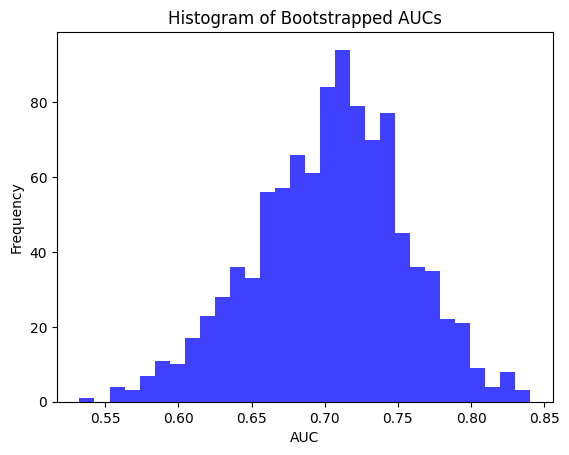

Shapiro-Wilk Test P-value: 0.004278706852346659
The data does not follow a normal distribution (reject H0 at 5% significance level).


In [15]:
def bootstrap_auc(dataframe, n_iterations=1000):
    bootstrapped_aucs = []
    for _ in range(n_iterations):
        # Sample with replacement
        sample_df = dataframe.sample(n=len(dataframe), replace=True)
        # Calculate AUC
        auc = roc_auc_score(sample_df['default'], sample_df['score'])
        bootstrapped_aucs.append(auc)
    return bootstrapped_aucs

# Create dataset
test_data = generate_independent_data(base_dataset_size * 1)
boot_aucs = bootstrap_auc(test_data)

# Histogram
plt.hist(boot_aucs, bins=30, alpha=0.75, color='blue')
plt.title('Histogram of Bootstrapped AUCs')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.show()

# Shapiro-Wilk Test
stat, p_value = stats.shapiro(boot_aucs)
print('Shapiro-Wilk Test P-value:', p_value)

# Interpret results
if p_value > 0.05:
    print("The data follows a normal distribution (fail to reject H0 at 5% significance level).")
else:
    print("The data does not follow a normal distribution (reject H0 at 5% significance level).")